In [1]:
import os
os.environ["MKL_NUM_THREADS"] = "1" 
os.environ["NUMEXPR_NUM_THREADS"] = "1" 
os.environ["OMP_NUM_THREADS"] = "1" 

from train import MCTS_HYPERPARAMETERS, load_from_checkpoint, collect_episode, train, rotate_training_examples
import torch
from resnet2 import ResNet2Heads
from utils import input_to_tensor_3d, input_to_tensor, input_to_tensor_scalar
import torch.multiprocessing as mp
from train import save_checkpoint, load_from_checkpoint, MetricsHistory, test_network, GameReplayMemory
import warnings
import matplotlib.pyplot as plt

In [11]:
MODEL_TO_LOAD = "" # place filename of checkpoint here, otherwise leave empty
LOAD_REPLAY_MEMORY = True
PLOT_EVERY = 1
WARMUP_AMOUNT = 1
NUM_COLLECTION_PROCS = 4
NUM_TRAIN_PROCS = 1

# HYPERPARAMETERS (will be ignored if loading from a checkpoint)
hyperparameters = MCTS_HYPERPARAMETERS() # use kwargs to specify non-default values


In [6]:
if MODEL_TO_LOAD:
    _, model, optimizer, hyperparameters, metrics_history, replay_memory, run_tag = load_from_checkpoint(MODEL_TO_LOAD, ResNet2Heads, load_replay_memory=LOAD_REPLAY_MEMORY)
else:

    # Set any hyperparameters you want to change here
    hyperparameters.replay_memory_size = 1000
    hyperparameters.minibatch_size = 128
    hyperparameters.weight_decay = 0.01
    hyperparameters.num_mcts_train_evals = 5
    hyperparameters.num_mcts_test_evals = 200
    hyperparameters.num_episodes = 100000
    hyperparameters.mcts_c_puct = 1
    hyperparameters.minibatches_per_episode = 16
    hyperparameters.lr = 1e-4
    hyperparameters.mcts_tau = 0.95
    hyperparameters.checkpoint_every = 250
    hyperparameters.c_prob = 50
    hyperparameters.episodes_per_epoch = 1000
    hyperparameters.num_epochs = 1000
    hyperparameters.num_eval_games = 200

    # init model, replay memory, optimizer, and metrics history
    model = ResNet2Heads()
    replay_memory = GameReplayMemory(hyperparameters.replay_memory_size)
    optimizer = torch.optim.AdamW(model.parameters(), lr=hyperparameters.lr, weight_decay=hyperparameters.weight_decay, amsgrad=True)
    metrics_history = MetricsHistory()
    run_tag = 'resnet64v2'     
    
    


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [4]:
# %prun -s tottime collect_episode(model, hyperparameters, input_to_tensor_scalar)

In [7]:
results = collect_episode(model, hyperparameters, input_to_tensor_scalar, epsilon=1.0)

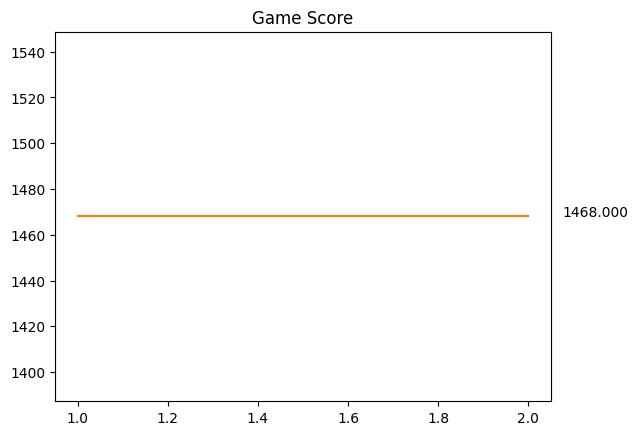

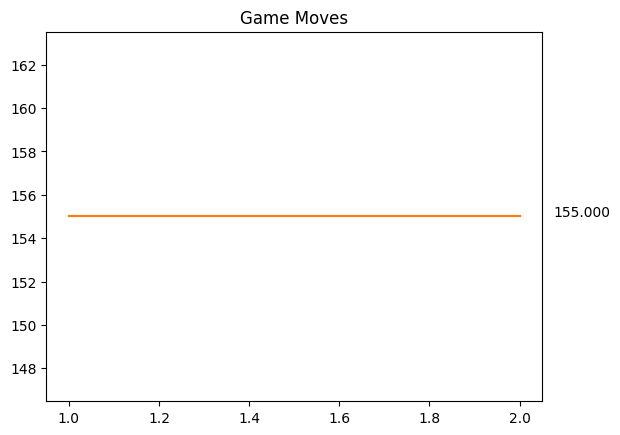

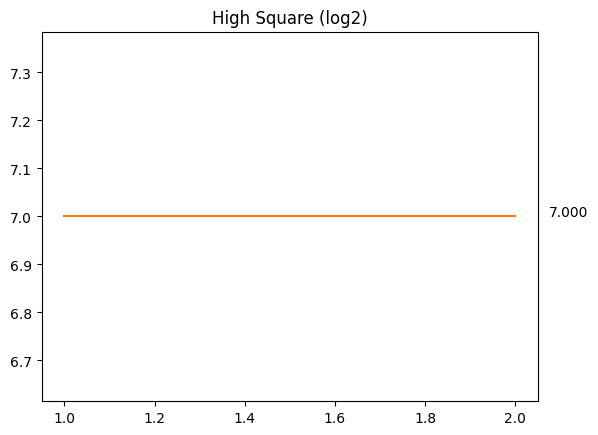

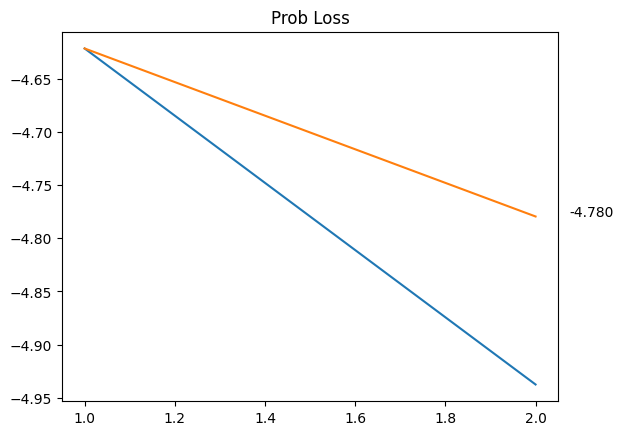

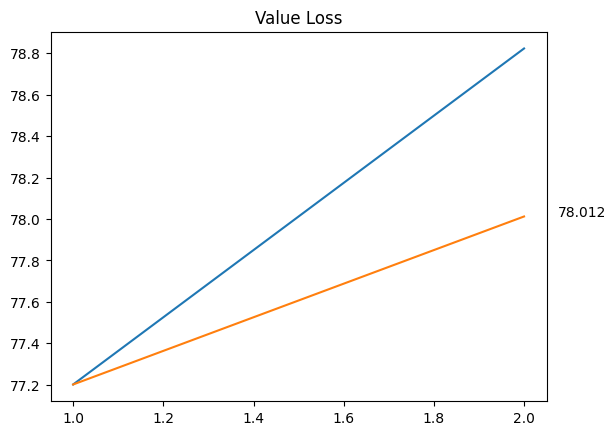

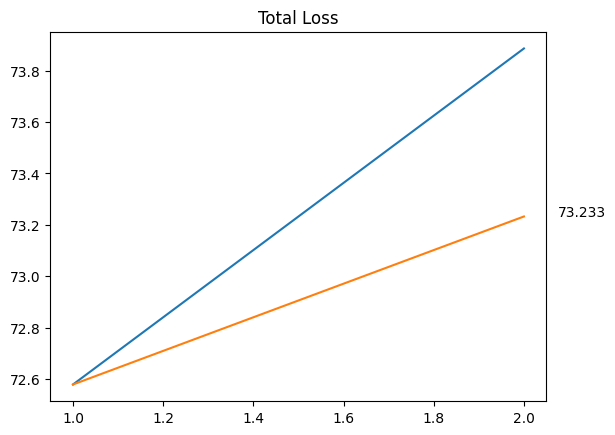

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

EPISODE 2
 Total Loss: 73.8857
 Prob Loss: -4.9374
 Value Loss: 78.8231
 Score: 1468
 Moves: 155
 Highest Square: 128



In [14]:
enque_and_train(results)

In [12]:
def enque_and_train(results):
    torch.set_num_threads(NUM_TRAIN_PROCS)
    
    training_examples, reward, moves, high_square, pid, score = results
    training_examples = rotate_training_examples(training_examples)
    replay_memory.insert(list(training_examples))
    
    if replay_memory.size() >= WARMUP_AMOUNT:
        cum_vl, cum_pl, cum_tl = 0.0, 0.0, 0.0
        for i in range(hyperparameters.minibatches_per_episode):
            value_loss, prob_loss, total_loss = train(replay_memory.sample(hyperparameters.minibatch_size), model, optimizer, tensor_conversion_fn=input_to_tensor_scalar, c_prob=hyperparameters.c_prob)
            cum_vl += value_loss
            cum_pl += prob_loss
            cum_tl += total_loss
            
        cum_vl /= hyperparameters.minibatches_per_episode
        cum_pl /= hyperparameters.minibatches_per_episode
        cum_tl /= hyperparameters.minibatches_per_episode

        new_best = metrics_history.add_training_history({
            'game_score': score,
            'game_moves': moves,
            'prob_loss': cum_pl,
            'value_loss': cum_vl,
            'total_loss': cum_tl,
            'high_square': high_square
        })

        if metrics_history.episodes % PLOT_EVERY == 0:
            metrics_history.plot_history(offset=5000, window_size=100)
        
        if new_best:
            print(f'*** NEW BEST {metrics_history.high_score_metric}: {metrics_history.best_training_result} ***')
        
        print(f'EPISODE {metrics_history.episodes}\n Total Loss: {cum_tl:.04f}\n Prob Loss: {cum_pl:.04f}\n Value Loss: {cum_vl:.04f}\n Score: {int(score)}\n Moves: {moves}\n Highest Square: {2 ** high_square}\n')
        
        if metrics_history.episodes % hyperparameters.checkpoint_every == 0:
            print('Saving model checkpoint...')
            save_checkpoint(metrics_history.episodes, model, optimizer, hyperparameters, metrics_history, replay_memory, run_tag=run_tag, save_replay_memory=True)
            print('Saved model checkpoint!')
    else:
        print(f'Replay memory size not large enough, {replay_memory.size()} < {WARMUP_AMOUNT}')

def enque_eval_results(results):
    reward, moves, high_square, score = results
    new_best = metrics_history.add_eval_history({
        'game_score': score,
        'game_moves': moves,
        'high_square': high_square
    })
    if new_best:
        print(f'*** NEW BEST EVAL {metrics_history.high_score_metric}: {metrics_history.best_eval_result} ***')
    

In [8]:

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    if metrics_history.episodes % hyperparameters.episodes_per_epoch == 0:
        print('Testing network...')
        with mp.Pool(NUM_COLLECTION_PROCS) as p:
            results = []
            for _ in range(hyperparameters.num_eval_games):
                results.append(p.apply_async(test_network, (model, hyperparameters, input_to_tensor_scalar, ), callback=enque_eval_results, error_callback=print))
            for r in results:
                r.wait()
        
        metrics_history.set_last_eval_plots()
        metrics_history.update_overall_eval_history()
        metrics_history.plot_history(offset=5000, window_size=100, plot_training=False)
        metrics_history.increment_epoch()

    for epoch in range(metrics_history.cur_epoch, hyperparameters.num_epochs + 1):
        print(f'Epoch {epoch} of {hyperparameters.num_epochs}')
        with mp.Pool(NUM_COLLECTION_PROCS) as p:
            results = []
            for episode in range(metrics_history.episodes, hyperparameters.episodes_per_epoch * (epoch+1)):
                epsilon = max(hyperparameters.mcts_epsilon_end, hyperparameters.mcts_epsilon_start - (episode * hyperparameters.mcts_epsilon_decay_rate))
                results.append(p.apply_async(collect_episode, (model, hyperparameters, input_to_tensor_scalar, epsilon, ), callback=enque_and_train, error_callback=print))
            for r in results:
                r.wait()


        print('Testing network...')
        # TODO: test network
        with mp.Pool(NUM_COLLECTION_PROCS) as p:
            results = []
            for _ in range(hyperparameters.num_eval_games):
                results.append(p.apply_async(test_network, (model, hyperparameters, input_to_tensor_scalar, ), callback=enque_eval_results, error_callback=print))
            for r in results:
                r.wait()
        
        metrics_history.set_last_eval_plots()
        metrics_history.update_overall_eval_history()
        metrics_history.plot_history(offset=5000, window_size=100, plot_training=False)
        metrics_history.increment_epoch()
        

Epoch 0 of 1000
